# CRAFTY Web Scraping. Flavio Romano, 614801

In [18]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt

"""Datasets"""
transactions = pd.read_csv("./datasets/transactions.csv", names=["timestamp", "blockID", "txID", "isCoinbase", "fee"])
inputs = pd.read_csv("./datasets/inputs.csv", names=["txID", "prev_txID", "prev_txPos"])
outputs = pd.read_csv("./datasets/outputs.csv", names=["txID", "position", "addressID", "amount", "scriptType"])
mapping_df = pd.read_csv("./datasets/mapAddr2Ids8708820.csv", names=["hash", "addressID"])

### Analisi generali sui dati

In [20]:
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')
print(transactions.head())
print(inputs.head())
print(outputs.head())
print(mapping_df.head())

    timestamp  blockID  txID  isCoinbase  fee
0  1231473279        9     9           1    0
1  1231635654       78    78           1    0
2  1231731025      170   171           0    0
3  1231740133      181   183           0    0
4  1231740736      182   185           0    0
   txID  prev_txID  prev_txPos
0   171          9           0
1   183        171           1
2   185        183           1
3   187        185           1
4   192        187           0
   txID  position  addressID      amount  scriptType
0     9         0          9  5000000000           1
1    78         0         78  5000000000           1
2   171         0        171  1000000000           1
3   171         1          9  4000000000           1
4   183         0        183  1000000000           1
                                 hash  addressID
0  1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa          0
1  12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX          1
2  1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1          2
3  1FvzCLoTPGANNjWoUo6jU

### Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato

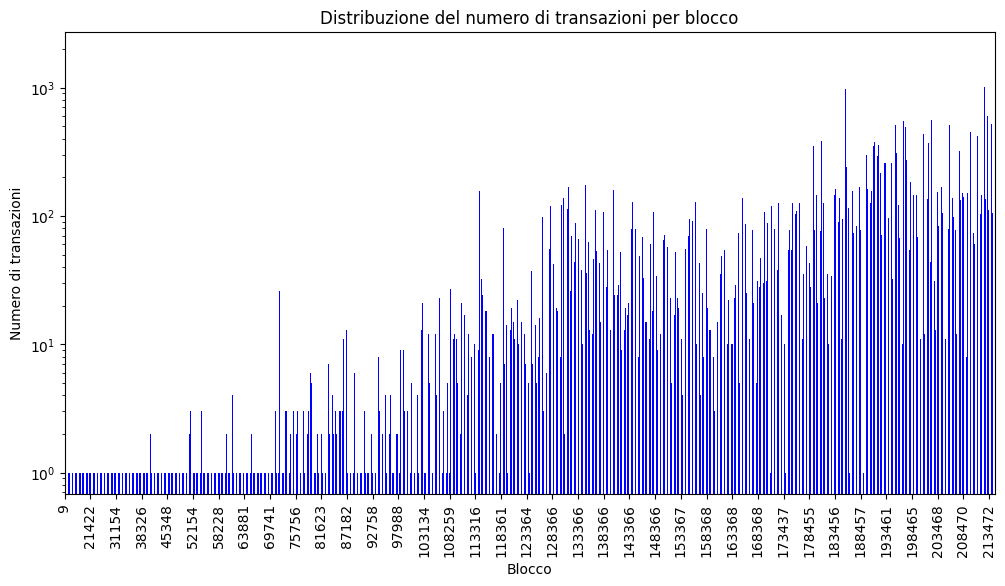

In [7]:
transactions_per_block = transactions.groupby("blockID")["txID"].count()

plt.figure(figsize=(12, 6))
transactions_per_block.plot(kind="bar", color="blue")
plt.xlabel("Blocco")
plt.ylabel("Numero di transazioni")
plt.title("Distribuzione del numero di transazioni per blocco")

plt.yscale("log")

x_ticks = range(0, len(transactions_per_block), 5000)
plt.xticks(x_ticks, transactions_per_block.index[x_ticks])

plt.show()

### Evoluzione dell'occupazione dei blocchi nel tempo

In [25]:
# Converti la colonna "timestamp" in formato datetime
transactions['timestamp'] = pd.to_datetime(
    transactions['timestamp'], unit='s')

  # Imposta la colonna "timestamp" come indice del DataFrame
transactions.set_index('timestamp', inplace=True)

   # Verifica se la colonna "txId" è presente nel DataFrame
if 'txID' in transactions.columns:
        # Calcola il numero di transazioni per ogni giorno
    transactions_per_day = transactions.groupby(
        transactions.index.date)['txId'].count()

    # Crea un nuovo DataFrame per contenere l'occupazione dei blocchi nel tempo
    block_occupancy_df = pd.DataFrame(transactions_per_day)

    # Converti l'indice in formato datetime
    block_occupancy_df.index = pd.to_datetime(block_occupancy_df.index)

    # Calcola l'occupazione media dei blocchi per ogni periodo di due mesi
    avg_transactions_per_period = block_occupancy_df.resample('2M').mean()

    # Crea un grafico a linee per mostrare l'evoluzione dell'occupazione dei blocchi nel tempo
    plt.figure(figsize=(12, 6))
    avg_transactions_per_period.plot(kind='line', color='blue')

    # Imposta le etichette degli assi e il titolo del grafico
    plt.xlabel('Data')
    plt.ylabel('Numero medio di transazioni')
    plt.title('Evoluzione dell\'occupazione dei blocchi nel tempo')

    # Mostra il grafico
    plt.show()
else:
    print("La colonna 'txId' non è presente nel DataFrame delle transazioni.")


KeyError: 'timestamp'